
# Sentiment Analysis


## 1.1) Load & Combine Data

In [2]:

# Load Data
import pandas as pd

df_yelp = pd.read_csv('./sentiment labelled sentences/yelp_labelled.txt', names=['sentence', 'label'], sep='\t')
df_amazon = pd.read_csv('./sentiment labelled sentences/amazon_cells_labelled.txt', names=['sentence', 'label'], sep='\t')
df_imdb = pd.read_csv('./sentiment labelled sentences/imdb_labelled.txt', names=['sentence', 'label'], sep='\t')

print("Yelp: ", df_yelp.shape)
print("Amazon: ", df_amazon.shape)
print("IMDB: ", df_imdb.shape)

df_all = pd.concat([df_yelp, df_amazon, df_imdb], ignore_index=True)
print("All: ", df_all.shape)
df_all.head()


Yelp:  (1000, 2)
Amazon:  (1000, 2)
IMDB:  (748, 2)
All:  (2748, 2)


,sentence,label
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


## 1.2) Explore Data

In [3]:

# Explore Data
import re, numpy as np, pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Dataset-wise label distribution (%)
for name, d in [('Yelp', df_yelp), ('Amazon', df_amazon), ('IMDB', df_imdb)]:
    percent = d['label'].value_counts(normalize=True, dropna=False).sort_index() * 100
    print(f"{name} Verteilung (%):\n", percent.round(2), "\n")

df = df_all.copy()

# Tokenizer (keeps simple English words and contractions like don't)
_token_re = re.compile(r"[A-Za-z]+(?:'[A-Za-z]+)?")
def tok(s): 
    if not isinstance(s, str): return []
    return _token_re.findall(s.lower())

# Grundüberblick
print("Shape:", df.shape)
print("Missing:", df.isna().sum().to_dict())
print("\nLabel-Verteilung (Count/%)")
counts = df['label'].value_counts().sort_index()
pct = (df['label'].value_counts(normalize=True).sort_index()*100).round(2)
display(pd.DataFrame({'count': counts, 'percent': pct}))

# Kern-Metriken je Text
def stats(text):
    s = text if isinstance(text, str) else ""
    t = tok(s)
    n = len(t)
    return pd.Series({
        'char_len': len(s),
        'word_len': n,
        'avg_word_len': (sum(len(x) for x in t)/n) if n else 0.0,
        'stop_ratio': (sum(x in ENGLISH_STOP_WORDS for x in t)/(n or 1)),
        'ttr': (len(set(t))/(n or 1)),
    })

fe = df['sentence'].apply(stats)
df_e = pd.concat([df[['label']], fe], axis=1)

print("\nGesamt-Deskriptoren:")
display(df_e.describe().round(3).T)

print("\nMittelwerte je Label:")
display(df_e.groupby('label').mean(numeric_only=True).round(3))

# N-Grams (Top 10)
def top_ngrams(texts, n=1, k=10, drop_stop=True):
    c = Counter()
    for s in texts:
        t = tok(s)
        if drop_stop: t = [w for w in t if w not in ENGLISH_STOP_WORDS]
        grams = t if n==1 else [" ".join(t[i:i+n]) for i in range(len(t)-n+1)]
        c.update(grams)
    return pd.DataFrame(c.most_common(k), columns=[f'{n}-gram','count'])

print("\nTop Unigrams (gesamt):")
display(top_ngrams(df['sentence'], n=1, k=10))

print("\nTop Bigrams (gesamt):")
display(top_ngrams(df['sentence'], n=2, k=10))

for lbl in sorted(df['label'].unique()):
    subset = df.loc[df['label']==lbl, 'sentence']
    print(f"\nTop Unigrams (Label={lbl}):")
    display(top_ngrams(subset, n=1, k=10))
    print(f"\nTop Bigrams (Label={lbl}):")
    display(top_ngrams(subset, n=2, k=10))

# Vokabulargröße (ohne Stopwords)
def vocab_size(texts):
    v=set()
    for s in texts: v.update([w for w in tok(s) if w not in ENGLISH_STOP_WORDS])
    return len(v)

print("\nVokabular gesamt (ohne Stopwords):", vocab_size(df['sentence']))
print("Vokabular je Label (ohne Stopwords):")
display(df.groupby('label')['sentence'].apply(vocab_size).to_frame('vocab_size'))


Yelp Verteilung (%):
 label
0    50.0
1    50.0
Name: proportion, dtype: float64 

Amazon Verteilung (%):
 label
0    50.0
1    50.0
Name: proportion, dtype: float64 

IMDB Verteilung (%):
 label
0    48.4
1    51.6
Name: proportion, dtype: float64 

Shape: (2748, 2)
Missing: {'sentence': 0, 'label': 0}

Label-Verteilung (Count/%)


,count,percent
label,,
0,1362,49.56
1,1386,50.44



Gesamt-Deskriptoren:


,count,mean,std,min,25%,50%,75%,max
label,2748.0,0.504,0.500,0.0,0.000,1.000,1.000,1.0
char_len,2748.0,71.620,204.405,7.0,32.000,55.000,87.000,8041.0
word_len,2748.0,12.896,33.489,0.0,6.000,10.000,16.000,1297.0
avg_word_len,2748.0,4.498,0.974,0.0,3.923,4.364,4.909,13.0
stop_ratio,2748.0,0.494,0.181,0.0,0.417,0.500,0.609,1.0
ttr,2748.0,0.956,0.073,0.0,0.917,1.000,1.000,1.0



Mittelwerte je Label:


,char_len,word_len,avg_word_len,stop_ratio,ttr
label,,,,,
0,74.437,13.467,4.462,0.515,0.955
1,68.852,12.334,4.533,0.474,0.956



Top Unigrams (gesamt):


,1-gram,count
0,good,231
1,great,210
2,movie,181
3,phone,165
4,film,160
5,food,126
6,like,125
7,just,119
8,place,114
9,it's,114



Top Bigrams (gesamt):


,2-gram,count
0,waste time,17
1,works great,17
2,customer service,15
3,sound quality,14
4,waste money,12
5,don't waste,11
6,highly recommend,11
7,battery life,11
8,don't think,10
9,i've seen,10



Top Unigrams (Label=0):


,1-gram,count
0,bad,96
1,movie,95
2,phone,78
3,film,71
4,just,69
5,like,67
6,food,66
7,time,62
8,don't,60
9,good,57



Top Bigrams (Label=0):


,2-gram,count
0,waste time,16
1,customer service,12
2,waste money,12
3,don't waste,11
4,don't think,8
5,i've seen,8
6,it's just,6
7,doesn't work,6
8,does work,6
9,don't buy,6



Top Unigrams (Label=1):


,1-gram,count
0,great,193
1,good,174
2,film,89
3,phone,87
4,movie,86
5,food,60
6,really,60
7,it's,60
8,best,59
9,place,58



Top Bigrams (Label=1):


,2-gram,count
0,works great,17
1,highly recommend,11
2,sound quality,10
3,great phone,9
4,great food,8
5,really good,8
6,great service,7
7,pretty good,7
8,food good,7
9,good quality,7



Vokabular gesamt (ohne Stopwords): 4903
Vokabular je Label (ohne Stopwords):


,vocab_size
label,
0,3111
1,3079


## 2.1) Text Cleaning

In [4]:

import re
import html
from html import unescape
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Optional: NLTK for lemmatization with safe fallback to stemming
use_lemmatize = True
try:
    import nltk
    from nltk.stem import WordNetLemmatizer
    nltk.data.find('corpora/wordnet')
    nltk.data.find('corpora/omw-1.4')
    _lemmatizer = WordNetLemmatizer()
except Exception:
    use_lemmatize = False

from nltk.stem import PorterStemmer
_stemmer = PorterStemmer()

# Basic contraction map (extend as needed)
CONTRACTIONS = {
    "ain't":"am not", "aren't":"are not", "can't":"cannot", "can't've":"cannot have",
    "could've":"could have", "couldn't":"could not", "didn't":"did not", "doesn't":"does not",
    "don't":"do not", "hadn't":"had not", "hasn't":"has not", "haven't":"have not",
    "he's":"he is", "she's":"she is", "it's":"it is", "i'm":"i am", "i've":"i have",
    "i'd":"i would", "i'll":"i will", "isn't":"is not", "let's":"let us", "mightn't":"might not",
    "mustn't":"must not", "shan't":"shall not", "shouldn't":"should not",
    "that's":"that is", "there's":"there is", "they're":"they are", "they've":"they have",
    "we're":"we are", "we've":"we have", "we'll":"we will", "weren't":"were not",
    "what's":"what is", "who's":"who is", "won't":"will not", "wouldn't":"would not",
    "you'd":"you would", "you'll":"you will", "you're":"you are", "y'all":"you all"
}

_url_re = re.compile(r"https?://\S+|www\.\S+", re.IGNORECASE)
_html_tag_re = re.compile(r"<[^>]+>")
_num_re = re.compile(r"\b\d+(?:[.,]\d+)?\b")
_punct_re = re.compile(r"[\.,!?:;\-\(\)\[\]\{\}\"\'`~\/_\\\|@#\$%\^&\*\+=><]+" )
_token_re = re.compile(r"[A-Za-z]+(?:'[A-Za-z]+)?")

def expand_contractions(text: str) -> str:
    def repl(match):
        c = match.group(0)
        return CONTRACTIONS.get(c.lower(), c)
    return re.sub(r"\b(" + "|".join(map(re.escape, CONTRACTIONS.keys())) + r")\b", repl, text, flags=re.IGNORECASE)

def basic_clean(text: str) -> str:
    if not isinstance(text, str):
        return ""
    s = html.unescape(text)
    s = _url_re.sub(" ", s)                 # remove URLs
    s = _html_tag_re.sub(" ", s)            # remove HTML tags
    s = expand_contractions(s)              # expand contractions
    s = _num_re.sub(" ", s)                 # remove numbers
    s = _punct_re.sub(" ", s)               # remove punctuation
    s = s.lower()
    s = re.sub(r"\s+", " ", s).strip()
    return s

def tokenize(text: str):
    return _token_re.findall(text)

def remove_stopwords(tokens, stopwords=ENGLISH_STOP_WORDS):
    return [t for t in tokens if t not in stopwords]

def normalize_tokens(tokens):
    out = []
    for t in tokens:
        if use_lemmatize:
            try:
                out.append(_lemmatizer.lemmatize(t))
            except Exception:
                out.append(_stemmer.stem(t))
        else:
            out.append(_stemmer.stem(t))
    return out

def clean_and_tokenize(text: str):
    s = basic_clean(text)
    toks = tokenize(s)
    toks = remove_stopwords(toks)
    toks = normalize_tokens(toks)
    return s, toks

# Apply cleaning
df['clean_text'], df['tokens'] = zip(*df['sentence'].map(clean_and_tokenize))

# Sentence lengths after cleaning (in tokens)
df['len_tokens'] = df['tokens'].apply(len)
df[['sentence','clean_text','label','len_tokens']].head()


,sentence,clean_text,label,len_tokens
0,Wow... Loved this place.,wow loved this place,1,3
1,Crust is not good.,crust is not good,0,2
2,Not tasty and the texture was just nasty.,not tasty and the texture was just nasty,0,4
3,Stopped by during the late May bank holiday of...,stopped by during the late may bank holiday of...,1,8
4,The selection on the menu was great and so wer...,the selection on the menu was great and so wer...,1,4


## 2.2) Exploratory Data Analysis (EDA)

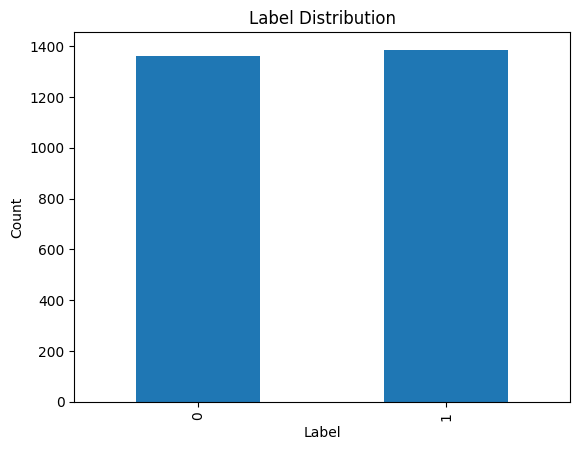

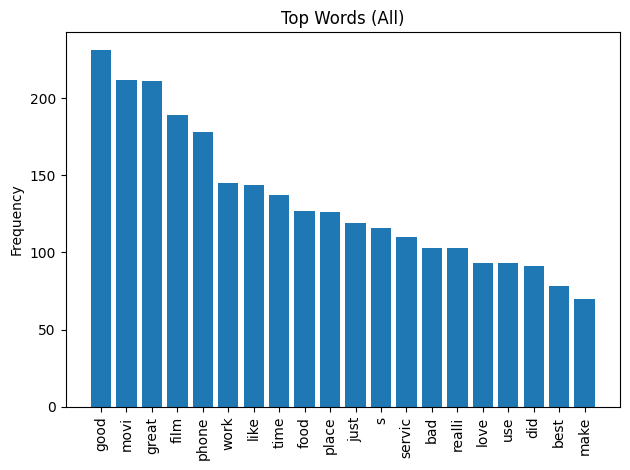

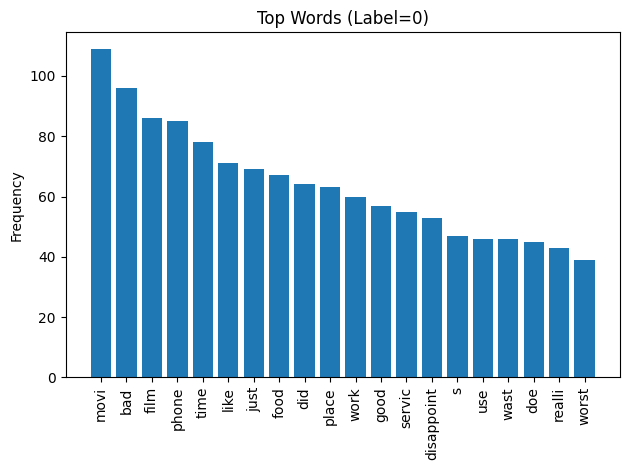

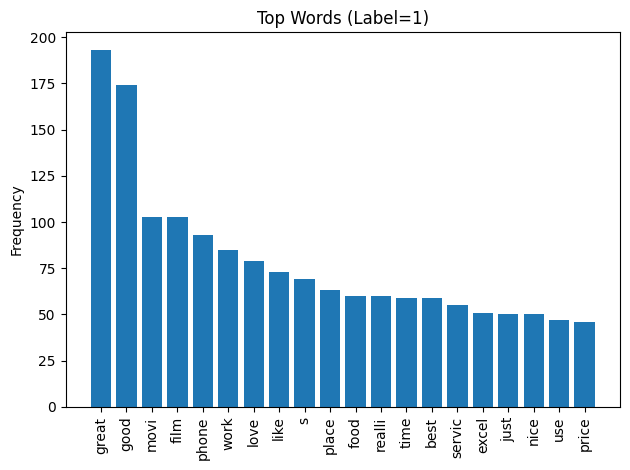

WordCloud not available: No module named 'wordcloud'


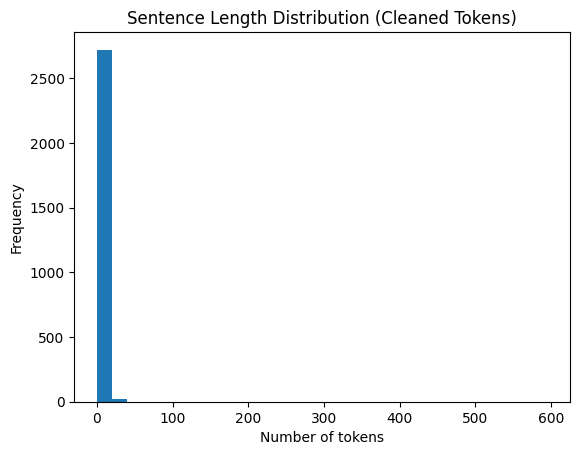

In [5]:

import matplotlib.pyplot as plt
from collections import Counter

# Label distribution (bar chart)
label_counts = df['label'].value_counts().sort_index()
plt.figure()
label_counts.plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Word frequency plots (top 20 global, and per class top 20)
def plot_top_words(token_series, title, top_k=20):
    freq = Counter([t for tokens in token_series for t in tokens])
    top = freq.most_common(top_k)
    words, counts = zip(*top) if top else ([], [])
    plt.figure()
    plt.bar(range(len(words)), counts)
    plt.xticks(range(len(words)), words, rotation=90)
    plt.title(title)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

plot_top_words(df['tokens'], 'Top Words (All)', top_k=20)

for lbl in sorted(df['label'].unique()):
    plot_top_words(df.loc[df['label']==lbl, 'tokens'], f'Top Words (Label={lbl})', top_k=20)

# Word cloud for each class
try:
    from wordcloud import WordCloud
    for lbl in sorted(df['label'].unique()):
        text_blob = " ".join([" ".join(toks) for toks in df.loc[df['label']==lbl, 'tokens']])
        if text_blob.strip():
            wc = WordCloud(width=800, height=400, background_color='white').generate(text_blob)
            plt.figure(figsize=(10,5))
            plt.imshow(wc, interpolation='bilinear')
            plt.axis('off')
            plt.title(f'Word Cloud (Label={lbl})')
            plt.show()
        else:
            print(f"No tokens for label {lbl} to build word cloud.")
except Exception as e:
    print("WordCloud not available:", e)

# Sentence length distribution (histogram over cleaned token lengths)
plt.figure()
df['len_tokens'].plot(kind='hist', bins=30)
plt.title('Sentence Length Distribution (Cleaned Tokens)')
plt.xlabel('Number of tokens')
plt.ylabel('Frequency')
plt.show()


## 2.3) Train/Validation/Test Split (70/15/15)

In [6]:

from sklearn.model_selection import train_test_split

X = df[['sentence','clean_text','tokens']].copy()
y = df['label'].astype(int)

# First: Train (70%) vs Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Second: Validation (15%) vs Test (15%) by splitting temp in half
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Shapes:")
print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

print("Saved: train_split.csv, val_split.csv, test_split.csv")


Shapes:
Train: (1923, 3) (1923,)
Val:   (412, 3) (412,)
Test:  (413, 3) (413,)
Saved: train_split.csv, val_split.csv, test_split.csv


## 3.1 TF-IDF features for classical ML

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Hyperparameters for TF-IDF
max_features = 5000       # Limit vocabulary size (can tune)
ngram_range = (1, 2)      # Use unigrams and bigrams

tfidf_vectorizer = TfidfVectorizer(
    max_features=max_features,
    ngram_range=ngram_range,
    stop_words='english'  # remove common English stopwords
)

X_train_text = X_train['clean_text'].astype(str)
X_val_text   = X_val['clean_text'].astype(str)
X_test_text  = X_test['clean_text'].astype(str)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_val_tfidf   = tfidf_vectorizer.transform(X_val_text)
X_test_tfidf  = tfidf_vectorizer.transform(X_test_text)

print("TF-IDF train shape:", X_train_tfidf.shape)
print("TF-IDF val shape:",   X_val_tfidf.shape)
print("TF-IDF test shape:",  X_test_tfidf.shape)


TF-IDF train shape: (1923, 5000)
TF-IDF val shape: (412, 5000)
TF-IDF test shape: (413, 5000)


## 3.2 Tokenization and Padding for Deep Learning Model

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 10000   # Size of the vocabulary (can tune)
max_len = 100       # Maximum sequence length (can tune)

X_train_text_dl = X_train['tokens'].apply(lambda toks: " ".join(toks))
X_val_text_dl   = X_val['tokens'].apply(lambda toks: " ".join(toks))
X_test_text_dl  = X_test['tokens'].apply(lambda toks: " ".join(toks))

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")

tokenizer.fit_on_texts(X_train_text_dl)

X_train_seq = tokenizer.texts_to_sequences(X_train_text_dl)
X_val_seq   = tokenizer.texts_to_sequences(X_val_text_dl)
X_test_seq  = tokenizer.texts_to_sequences(X_test_text_dl)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_pad   = pad_sequences(X_val_seq,   maxlen=max_len, padding='post', truncating='post')
X_test_pad  = pad_sequences(X_test_seq,  maxlen=max_len, padding='post', truncating='post')

print("Padded train shape:", X_train_pad.shape)
print("Padded val shape:",   X_val_pad.shape)
print("Padded test shape:",  X_test_pad.shape)

# For later use in the DL model:
word_index = tokenizer.word_index
print("Size of word_index (vocabulary):", len(word_index))


Padded train shape: (1923, 100)
Padded val shape: (412, 100)
Padded test shape: (413, 100)
Size of word_index (vocabulary): 3179


## 4.1 Classical Model: Logistic Regression with TF-IDF

Validation classification report (Logistic Regression):
              precision    recall  f1-score   support

           0      0.739     0.804     0.770       204
           1      0.789     0.721     0.754       208

    accuracy                          0.762       412
   macro avg      0.764     0.763     0.762       412
weighted avg      0.764     0.762     0.762       412

Test classification report (Logistic Regression):
              precision    recall  f1-score   support

           0      0.804     0.800     0.802       205
           1      0.804     0.808     0.806       208

    accuracy                          0.804       413
   macro avg      0.804     0.804     0.804       413
weighted avg      0.804     0.804     0.804       413

Test Accuracy: 0.804


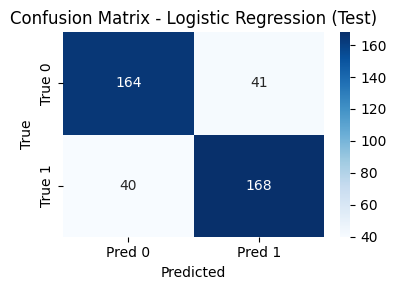

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt

y_train_cls = y_train
y_val_cls   = y_val
y_test_cls  = y_test

log_reg = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,
    class_weight=None,   # you could set 'balanced' if classes were imbalanced
    solver='lbfgs'
)

log_reg.fit(X_train_tfidf, y_train_cls)

# Validation performance
y_val_pred = log_reg.predict(X_val_tfidf)

print("Validation classification report (Logistic Regression):")
print(classification_report(y_val_cls, y_val_pred, digits=3))

# Test performance
y_test_pred = log_reg.predict(X_test_tfidf)

print("Test classification report (Logistic Regression):")
print(classification_report(y_test_cls, y_test_pred, digits=3))

# Accuracy shortcut
test_acc = accuracy_score(y_test_cls, y_test_pred)
print(f"Test Accuracy: {test_acc:.3f}")

# Confusion matrix on test set
cm = confusion_matrix(y_test_cls, y_test_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['True 0', 'True 1'])
plt.title('Confusion Matrix - Logistic Regression (Test)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


## 4.2 Deep Learning Model: BiLSTM

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

embedding_dim = 100
lstm_units = 64
dropout_rate = 0.5
batch_size = 64
epochs = 20

y_train_dl = np.array(y_train)
y_val_dl   = np.array(y_val)
y_test_dl  = np.array(y_test)

vocab_size = min(max_words, len(word_index) + 1)

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    Bidirectional(LSTM(lstm_units, return_sequences=False)),
    Dropout(dropout_rate),
    Dense(64, activation='relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')  # binary classification
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train_pad, y_train_dl,
    validation_data=(X_val_pad, y_val_dl),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop],
    verbose=1
)


c:\Users\Alex\Documents\GitHub\FH\WS25\NLP\.env\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.5075 - loss: 0.7149 - val_accuracy: 0.5049 - val_loss: 0.7100
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.5481 - loss: 0.7053 - val_accuracy: 0.5510 - val_loss: 0.6991
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.6505 - loss: 0.6780 - val_accuracy: 0.7403 - val_loss: 0.6514
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.7816 - loss: 0.5696 - val_accuracy: 0.7718 - val_loss: 0.5171
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8586 - loss: 0.3900 - val_accuracy: 0.8010 - val_loss: 0.4471
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9184 - loss: 0.2610 - val_accuracy: 0.7937 - val_loss: 0.4591
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9293 - loss: 0.2192 - val_accuracy: 0.7864 - val_loss: 0.5081


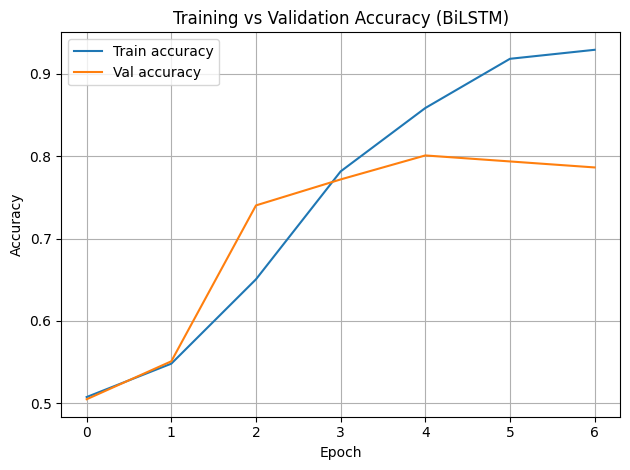

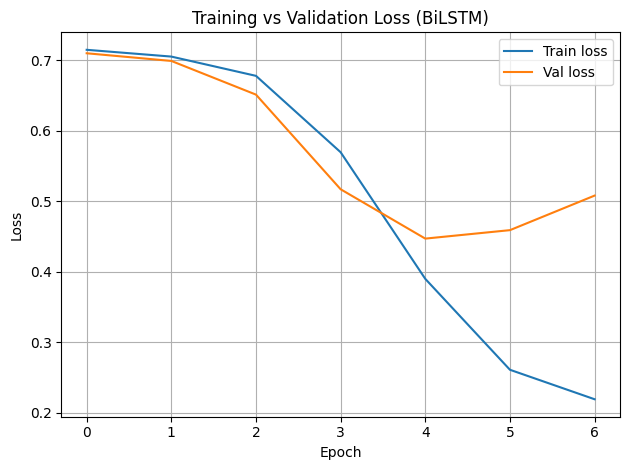

In [31]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.title('Training vs Validation Accuracy (BiLSTM)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot loss
plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title('Training vs Validation Loss (BiLSTM)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Test Loss (BiLSTM): 0.506
Test Accuracy (BiLSTM): 0.770
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step

Classification report (BiLSTM):
              precision    recall  f1-score   support

           0      0.799     0.717     0.756       205
           1      0.747     0.822     0.783       208

    accuracy                          0.770       413
   macro avg      0.773     0.770     0.769       413
weighted avg      0.773     0.770     0.769       413



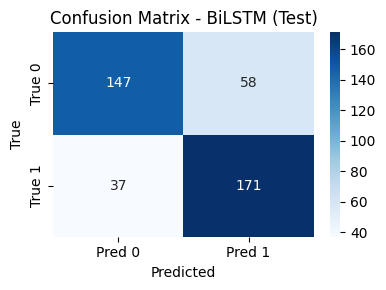

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Evaluate loss & accuracy directly
test_loss, test_acc = model.evaluate(X_test_pad, y_test_dl, verbose=0)
print(f"Test Loss (BiLSTM): {test_loss:.3f}")
print(f"Test Accuracy (BiLSTM): {test_acc:.3f}")

# Predicted probabilities and class labels
y_test_proba = model.predict(X_test_pad).ravel()
y_test_pred_dl = (y_test_proba >= 0.5).astype(int)

print("\nClassification report (BiLSTM):")
print(classification_report(y_test_dl, y_test_pred_dl, digits=3))

cm_dl = confusion_matrix(y_test_dl, y_test_pred_dl)
plt.figure(figsize=(4,3))
sns.heatmap(cm_dl, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['True 0', 'True 1'])
plt.title('Confusion Matrix - BiLSTM (Test)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()
